# VietNam sign language train model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
import numpy as np
import glob
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from prettytable import PrettyTable

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


# Data exploration

In [ ]:
# mỗi frame là 1 sample
def extract_framewise_features_from_json(json_file):
  with open(json_file, 'r') as f:
    data = json.load(f)

  samples = []
  for frame in data:
    landmarks = frame.get("landmarks", [])
    if len(landmarks) != 21:
      continue
    coords = []
    for point in landmarks:
      coords.extend([point["x"], point["y"], point["z"]])
    samples.append(coords)  # 63 chiều mỗi frame

  return samples  # danh sách các frame


In [ ]:
base_path = '/content/drive/MyDrive/dataset/vn_language_sign_preDataset'
label_map = { "A": 0, "B": 1, "C": 2, "D": 3, "E": 4 }

X, y = [], []

for label_name in label_map:
  label_folder = os.path.join(base_path, label_name)
  json_files = glob.glob(os.path.join(label_folder, '*.json'))
  for json_file in json_files:
    frames = extract_framewise_features_from_json(json_file)
    for frame in frames:
      X.append(frame)
      y.append(label_map[label_name])



In [ ]:
# check shape
X = np.array(X)
y = np.array(y)
print(X.shape)  # -> (số mẫu, 63)
print(y.shape)  # -> (số mẫu,)


(7554, 63)
(7554,)


In [ ]:
# # save dataset

# df = pd.DataFrame(X)
# df['label'] = y
# df.to_csv('/content/drive/MyDrive/dataset/processed_dataset.csv', index=False)

In [ ]:
df = pd.DataFrame(X)
df['label'] = y
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,label
0,0.218829,0.776617,-5.939527e-07,0.290068,0.709069,-0.025122,0.334494,0.592360,-0.034854,0.349805,...,0.172989,0.446159,-0.045552,0.181369,0.526937,-0.032771,0.183864,0.574545,-0.013420,0
1,0.217804,0.772329,-5.115557e-07,0.285080,0.715410,-0.027397,0.333580,0.594418,-0.035990,0.347335,...,0.175573,0.443233,-0.041881,0.183260,0.528279,-0.030134,0.186733,0.577970,-0.010293,0
2,0.218481,0.771083,-4.992582e-07,0.284539,0.715398,-0.027413,0.333331,0.594329,-0.035810,0.347977,...,0.174969,0.442161,-0.042810,0.183112,0.528131,-0.031463,0.187377,0.579171,-0.011709,0
3,0.218091,0.767711,-5.004063e-07,0.284505,0.714629,-0.027764,0.334246,0.594312,-0.035989,0.348844,...,0.175647,0.442189,-0.042317,0.182685,0.528399,-0.030847,0.186226,0.578450,-0.011077,0
4,0.219105,0.768287,-5.056602e-07,0.285074,0.714390,-0.027025,0.334230,0.592762,-0.034838,0.348439,...,0.175476,0.441800,-0.042377,0.182592,0.528149,-0.031361,0.186102,0.579079,-0.011827,0


In [ ]:
print("Thông tin tổng quát:")
print(df.info())

Thông tin tổng quát:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7554 non-null   float64
 1   1       7554 non-null   float64
 2   2       7554 non-null   float64
 3   3       7554 non-null   float64
 4   4       7554 non-null   float64
 5   5       7554 non-null   float64
 6   6       7554 non-null   float64
 7   7       7554 non-null   float64
 8   8       7554 non-null   float64
 9   9       7554 non-null   float64
 10  10      7554 non-null   float64
 11  11      7554 non-null   float64
 12  12      7554 non-null   float64
 13  13      7554 non-null   float64
 14  14      7554 non-null   float64
 15  15      7554 non-null   float64
 16  16      7554 non-null   float64
 17  17      7554 non-null   float64
 18  18      7554 non-null   float64
 19  19      7554 non-null   float64
 20  20      7554 non-null   float64
 21  21      7554 non



> Có 7554 dòng dữ liệu, mỗi dòng tương ứng với tạo đồ điểm khớp của bàn tay trong một frame



In [ ]:
print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isnull().sum())


Số lượng giá trị thiếu mỗi cột:
0        0
1        0
2        0
3        0
4        0
        ..
59       0
60       0
61       0
62       0
label    0
Length: 64, dtype: int64




> Không có cột giá trị bị thiếu trong dataset



/tmp/ipython-input-35-2253378640.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='pastel', edgecolor='black')


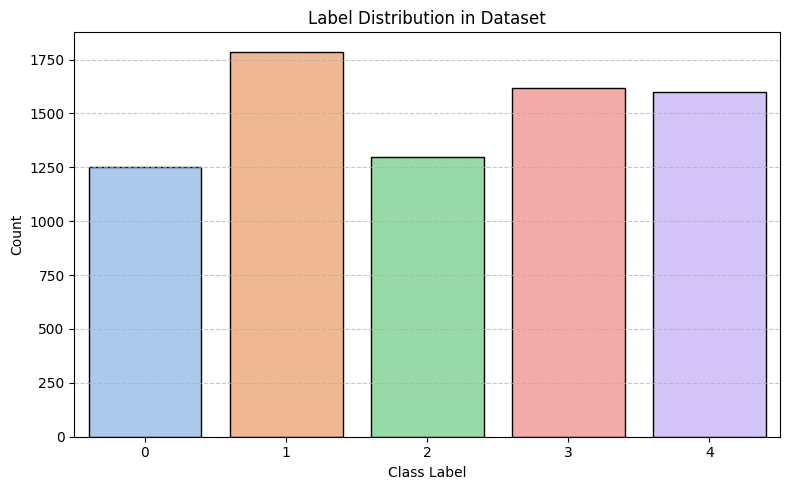

In [ ]:
# Tạo dataframe từ y
df = pd.DataFrame({'label': y})

plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='pastel', edgecolor='black')

plt.title('Label Distribution in Dataset')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




> Các mẫu dữ liệu phân bố tương đối đồng đều, chưa cần phải xử lý mất cân bằng dữ liệu ở hiện tại



# Train model

## Utils

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:


def evaluate_models_with_prettytable(models, model_names, X_test, y_test):
  table = PrettyTable()
  table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

  for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    table.add_row([name, f"{accuracy:.5f}", f"{precision:.5f}", f"{recall:.5f}", f"{f1:.5f}"])

  print(table)


In [ ]:


random_fr_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_fr_model.fit(X_train, y_train)

y_pred = random_fr_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.99933818663137
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       358
           2       1.00      1.00      1.00       259
           3       1.00      1.00      1.00       324
           4       1.00      1.00      1.00       320

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



In [ ]:
# Accuracy trên tập huấn luyện
train_acc = random_fr_model.score(X_train, y_train)

# Accuracy trên tập kiểm tra
test_acc = random_fr_model.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.5f}")
print(f"Test accuracy: {test_acc:.5f}")


Train accuracy: 1.00000
Test accuracy: 0.99934


> Không có dấu hiệu của overffitting

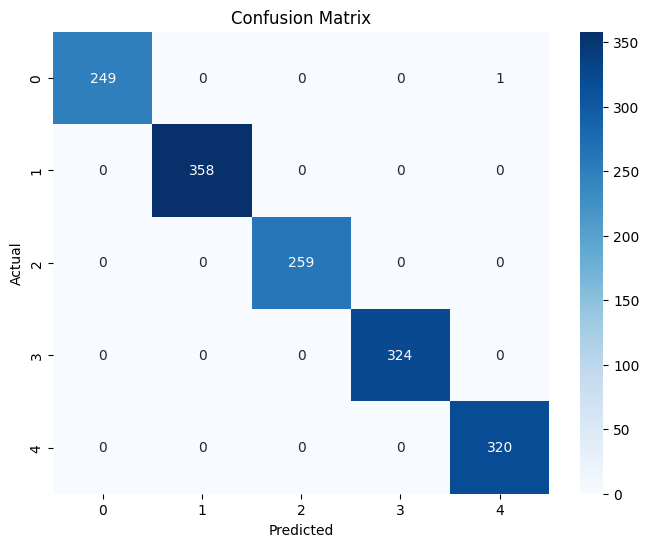

In [ ]:


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



> Mô hình đa phần dự đoán đúng các nhãn



## SVM

In [ ]:

SVM_model = SVC(kernel='linear', C=1, gamma='scale')
SVM_model.fit(X_train, y_train)

y_pred = SVM_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9589675711449371
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       250
           1       0.99      0.96      0.97       358
           2       1.00      0.97      0.98       259
           3       0.85      1.00      0.92       324
           4       0.99      0.93      0.96       320

    accuracy                           0.96      1511
   macro avg       0.97      0.96      0.96      1511
weighted avg       0.96      0.96      0.96      1511



## LogisticRegression

In [ ]:

lg_model = LogisticRegression(max_iter=1000)
lg_model.fit(X_train, y_train)

y_pred = lg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9543348775645268
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       250
           1       0.99      0.96      0.97       358
           2       1.00      0.97      0.98       259
           3       0.95      0.97      0.96       324
           4       0.94      0.93      0.94       320

    accuracy                           0.95      1511
   macro avg       0.95      0.95      0.95      1511
weighted avg       0.96      0.95      0.95      1511



## MLP

In [ ]:

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300)
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9960291197882197
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       250
           1       0.99      1.00      1.00       358
           2       1.00      1.00      1.00       259
           3       1.00      1.00      1.00       324
           4       0.99      1.00      1.00       320

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



# Evaluate

In [ ]:
evaluate_models_with_prettytable(
  models=[random_fr_model, SVM_model, lg_model, mlp_model],
  model_names=["random forest", "SVM", "Logistic Regression", "MLP"],
  X_test=X_test,
  y_test=y_test
)


+---------------------+----------+-----------+---------+----------+
|        Model        | Accuracy | Precision |  Recall | F1-Score |
+---------------------+----------+-----------+---------+----------+
|    random forest    | 0.99934  |  0.99934  | 0.99934 | 0.99934  |
|         SVM         | 0.95897  |  0.96426  | 0.95897 | 0.95985  |
| Logistic Regression | 0.95433  |  0.95525  | 0.95433 | 0.95458  |
|         MLP         | 0.99603  |  0.99606  | 0.99603 | 0.99601  |
+---------------------+----------+-----------+---------+----------+






> * Nhìn chung các model có chỉ số khá tốt nên chưa cần phải fine turn hyperparameter
* Thuật toán random forest cho thấy hiệu quả nhất đối với dataset này khi chỉ số Accuracy là 99,93%. Các chỉ số khác điều cao hơn các model còn lại





In [ ]:
# # lưu model
# import joblib

# joblib.dump(random_fr_model, '/content/drive/MyDrive/dataset/vn_sign_language_best.pkl')